<div align="center" style="margin-bottom: 0; color: #cb76dd;">
    <h1 style="margin: 0;">5IC-IG2 Traitement flux vidéo
</h1>
    <h4 style="margin: 15px 0;">2024 - 2025, ESIEE-IT</h4>
    <h4 style="margin: 5px 0;">Enseigné par Badr TAJINI</h4>
</div>

<br><br>

<div align="center" style="margin-bottom: 0; color: #005E99;">
    <h2 style="margin: 0;">TD6 : Driving video with object tracking</h2>
    <h4 style="margin: 5px 0;">Réalisé par Samuel CRDOSO & Kevin TCHA</h4>
</div>

<br> 

---

# Packages nécessaires pour travailler avec des vidéos

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import subprocess
from IPython.display import Video as ipdVideo
from tqdm import tqdm
import IPython.display as ipd

# Style des graphiques
plt.style.use('ggplot')

print("Bibliothèques importées avec succès.")

Bibliothèques importées avec succès.


# Conversion de la vidéo en mp4

In [2]:
input_file = '026b9a11-f819c1b9.mov'
output_file = input_file.replace('.mov', '.mp4')

# Fonction pour convertir une vidéo à l'aide de ffmpeg
def convert_video_to_mp4(input_file, output_file):
    try:
        subprocess.run(['ffmpeg',
                        '-i', input_file,
                        '-qscale', '0',  # Qualité maximale
                        output_file,
                        '-loglevel', 'quiet'])  # Supprime les logs
        print(f"Conversion terminée : {output_file}")
    except Exception as e:
        print(f"Erreur lors de la conversion : {e}")

convert_video_to_mp4(input_file, output_file)

Conversion terminée : 026b9a11-f819c1b9.mp4


# Affichage de la vidéo dans le notebook

In [3]:
ipd.Video(output_file, width=700)

# Métadonnées de la vidéo

In [4]:
# Fonction pour lire les métadonnées d'une vidéo
def get_video_metadata(video_path):
    cap = cv2.VideoCapture(video_path)
    metadata = {
        'frame_count': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'fps': cap.get(cv2.CAP_PROP_FPS),
    }
    cap.release()
    return metadata

# Lecture et affichage des métadonnées
metadata = get_video_metadata(output_file)
print(f"Métadonnées pour {output_file} :")
print(f" - Nombre total de frames : {metadata['frame_count']}")
print(f" - Hauteur : {metadata['height']} pixels")
print(f" - Largeur : {metadata['width']} pixels")
print(f" - FPS : {metadata['fps']:0.2f}")

Métadonnées pour 026b9a11-f819c1b9.mp4 :
 - Nombre total de frames : 1205
 - Hauteur : 720 pixels
 - Largeur : 1280 pixels
 - FPS : 29.97


# Extraction et affichage de la première image

Image extraite avec succès de 026b9a11-f819c1b9.mp4. Dimensions : (720, 1280, 3)


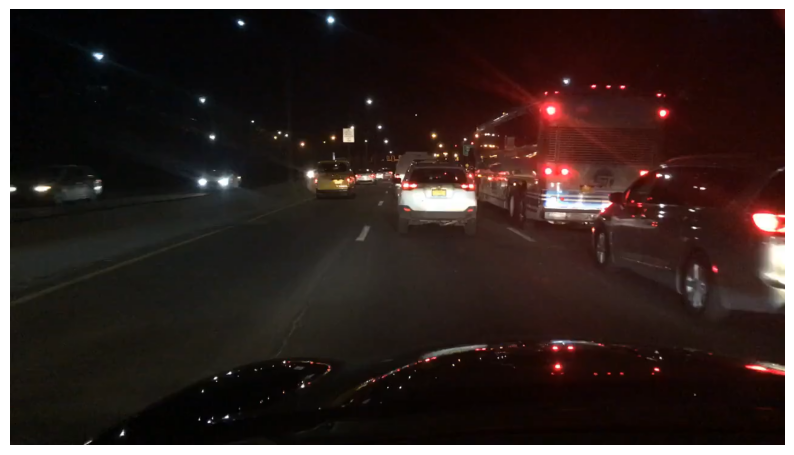

In [5]:
def display_cv2_img(img, figsize=(10, 10)):
    """
    Affiche une image OpenCV convertie en format RGB.
    """
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(img_rgb)
        ax.axis("off")
        plt.show()
    else:
        print("Aucune image à afficher.")

def extract_first_frame(video_path):
    """
    Lit la première frame d'une vidéo et retourne l'image.
    """
    cap = cv2.VideoCapture(video_path)
    ret, img = cap.read()
    cap.release()

    if ret:
        print(f"Image extraite avec succès de {video_path}. Dimensions : {img.shape}")
        return img
    else:
        print(f"Échec de la lecture de la vidéo : {video_path}")
        return None

# Extraction et affichage de la première image
first_frame = extract_first_frame(output_file)
display_cv2_img(first_frame)

# Affichage de plusieurs frames d'une vidéo

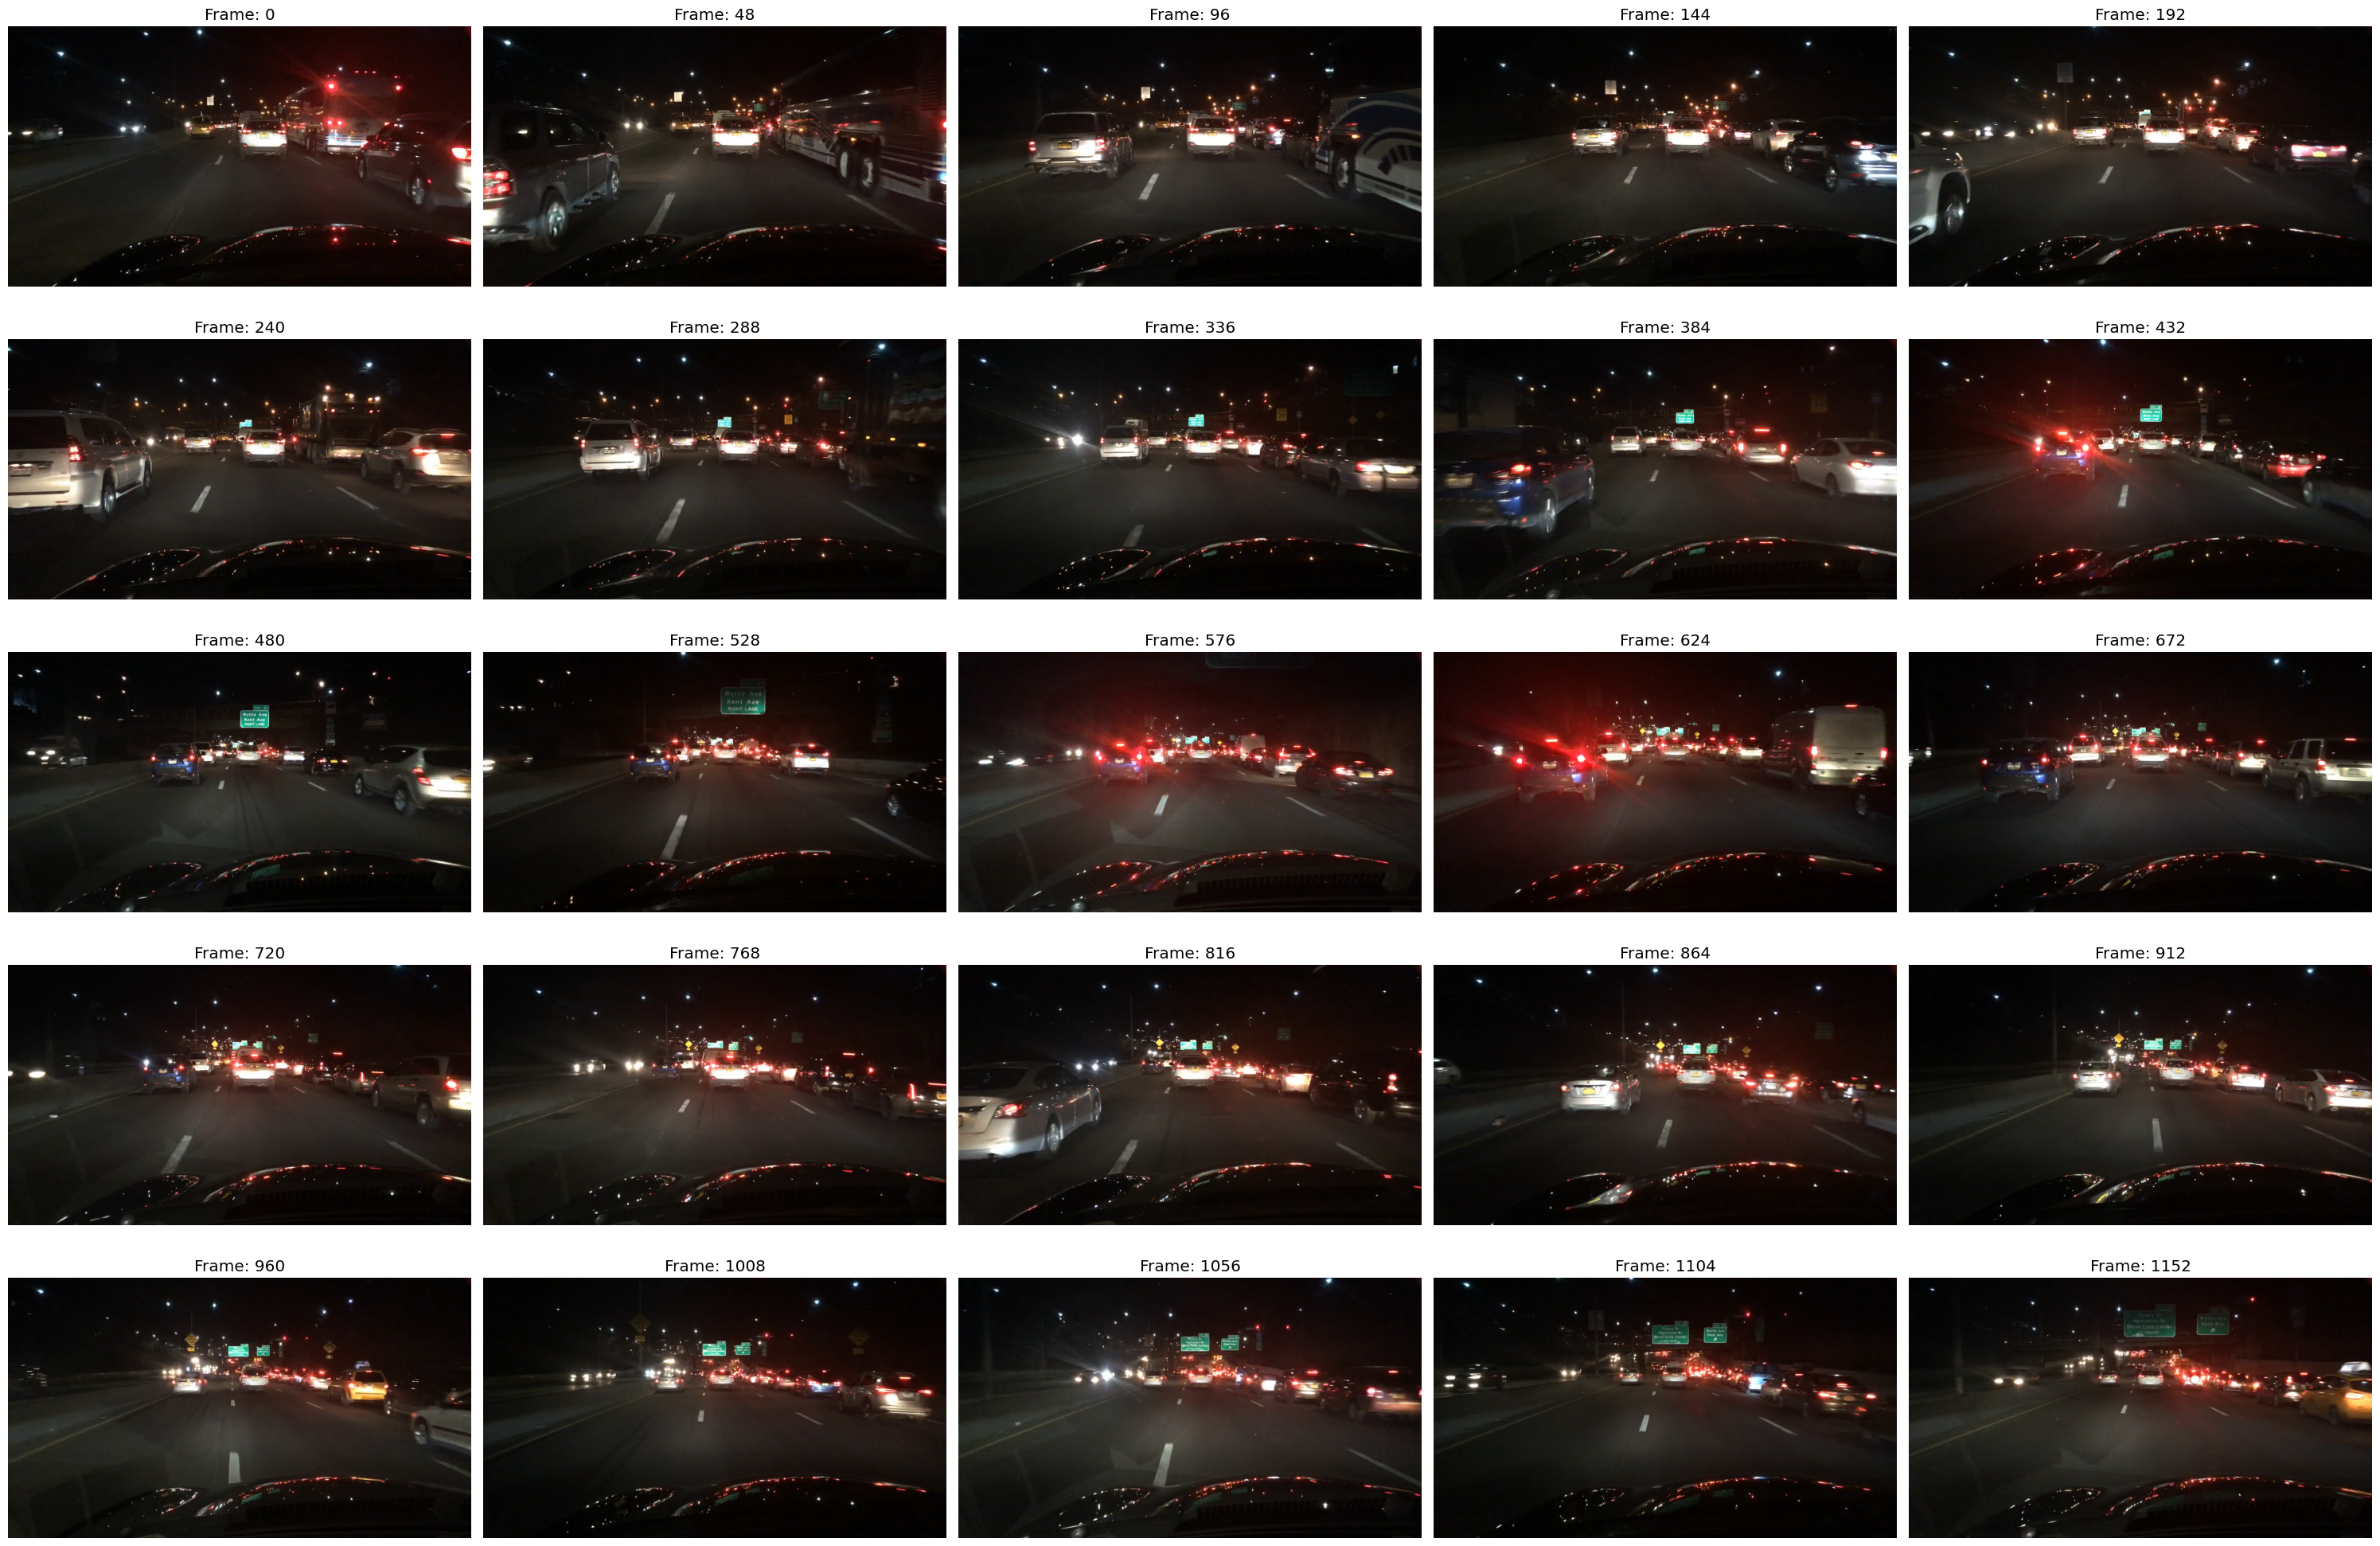

In [27]:
def display_multiple_frames(video_path, step=100, max_frames=25, figsize=(30, 20)):
    """
    Affiche plusieurs frames extraites d'une vidéo.
    - video_path : chemin de la vidéo
    - step : intervalle de frames à sauter entre chaque extraction
    - max_frames : nombre maximum de frames à afficher
    - figsize : taille de la figure matplotlib
    """
    cap = cv2.VideoCapture(video_path)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fig, axs = plt.subplots(5, 5, figsize=figsize)
    axs = axs.flatten()

    img_idx = 0
    for frame in range(0, n_frames, step):
        if img_idx >= max_frames:  # Arrêt après avoir atteint le nombre max de frames
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame)  # On se positionne sur une frame spécifique
        ret, img = cap.read()

        if ret:
            axs[img_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axs[img_idx].set_title(f'Frame: {frame}')
            axs[img_idx].axis('off')
            img_idx += 1
        else:
            print(f"Échec de la lecture de la frame {frame}")

    plt.tight_layout()
    plt.show()
    cap.release()

# Affichage de plusieurs frames de la vidéo
display_multiple_frames(output_file, step=metadata['frame_count'] // 25, max_frames=25)

# Ajout d'annotations sur les images vidéo

In [7]:
def annotate_frame(img, frame_labels, color=(0, 0, 255)):
    """
    Ajoute des annotations sur une image.
    - img : image OpenCV.
    - frame_labels : DataFrame contenant les labels pour la frame spécifique.
    - color : couleur des rectangles (BGR).
    """
    for _, label in frame_labels.iterrows():
        pt1 = int(label["box2d.x1"]), int(label["box2d.y1"])
        pt2 = int(label["box2d.x2"]), int(label["box2d.y2"])
        cv2.rectangle(img, pt1, pt2, color, 3)
    return img

def load_video_labels(label_file, video_name):
    """
    Charge les labels associés à une vidéo spécifique.
    - label_file : chemin du fichier CSV contenant les labels.
    - video_name : nom de la vidéo (sans extension).
    """
    labels = pd.read_csv(label_file, low_memory=False)
    video_labels = (
        labels.query(f'videoName == "{video_name.split(".")[0]}"')
        .reset_index(drop=True)
        .copy()
    )
    video_labels["video_frame"] = (video_labels["frameIndex"] * 11.9).round().astype("int")
    return video_labels

def generate_annotated_video(input_video, output_video, video_labels, color=(0, 0, 255), fps=30):
    """
    Génère une nouvelle vidéo annotée à partir d'une vidéo source.
    - input_video : chemin de la vidéo source.
    - output_video : chemin de la vidéo annotée à générer.
    - video_labels : DataFrame contenant les labels associés.
    - color : couleur des rectangles (BGR) pour les annotations.
    - fps : nombre d'images par seconde pour la vidéo générée.
    """
    cap = cv2.VideoCapture(input_video)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    out = cv2.VideoWriter(
        output_video,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (frame_width, frame_height)
    )

    for frame in tqdm(range(n_frames), desc="Annotating video"):
        ret, img = cap.read()
        if not ret:
            break

        # Récupération des labels pour la frame courante
        frame_labels = video_labels.query(f'video_frame == {frame}')
        if not frame_labels.empty:
            img = annotate_frame(img, frame_labels, color=color)

        out.write(img)

    cap.release()
    out.release()
    print(f"Vidéo annotée générée : {output_video}")

# Chargement des labels pour la vidéo
label_file = './mot_labels/mot_labels.csv'
input_video = output_file
output_video = output_file.replace('.mp4', '_annotated.mp4')

video_name = input_video.split(".")[0]
video_labels = load_video_labels(label_file, video_name)

if video_labels.empty:
    print(f"Aucun label chargé pour la vidéo {video_name}. Vérifiez le fichier CSV.")
else:
    # Affichage d'un résumé des labels
    print(f"Labels chargés pour la vidéo '{video_name}':")
    print(f"- Nombre total de labels : {len(video_labels)}")
    print(f"- Catégories trouvées :")
    print(video_labels["category"].value_counts())

    # Génération de la vidéo annotée
    generate_annotated_video(input_video, output_video, video_labels, color=(0, 0, 255), fps=30)

Labels chargés pour la vidéo '026b9a11-f819c1b9':
- Nombre total de labels : 3271
- Catégories trouvées :
category
car      3146
truck      75
bus        50
Name: count, dtype: int64


Annotating video: 100%|██████████| 1205/1205 [00:18<00:00, 66.54it/s]

Vidéo annotée générée : 026b9a11-f819c1b9_annotated.mp4


# Affichage des annotations colorées par catégorie

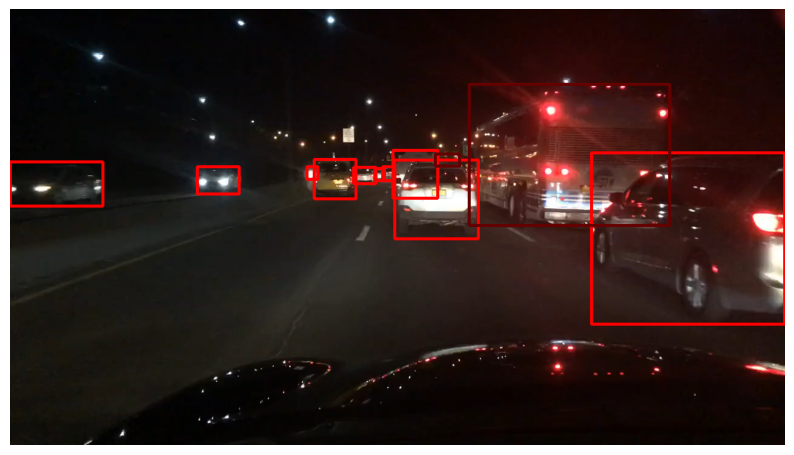

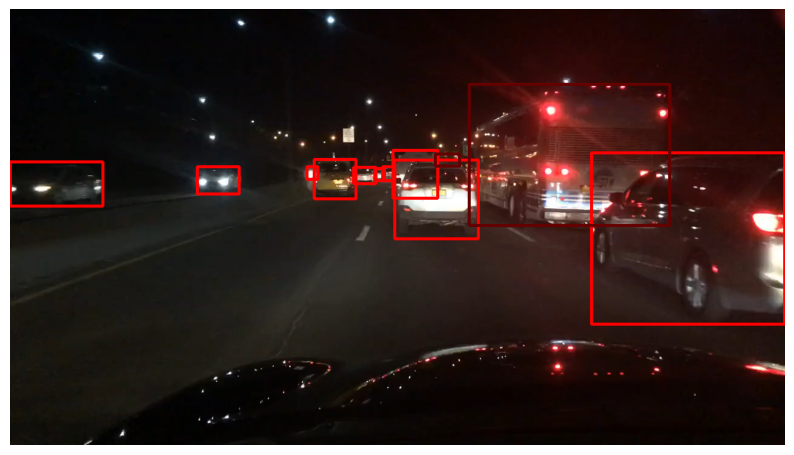

array([[[ 5,  3,  3],
        [ 5,  3,  3],
        [ 5,  3,  3],
        ...,
        [13, 18, 77],
        [14, 19, 78],
        [14, 19, 78]],

       [[ 5,  3,  3],
        [ 5,  3,  3],
        [ 5,  3,  3],
        ...,
        [13, 18, 77],
        [14, 19, 78],
        [14, 19, 78]],

       [[ 5,  3,  3],
        [ 5,  3,  3],
        [ 5,  3,  3],
        ...,
        [13, 18, 77],
        [14, 19, 78],
        [14, 19, 78]],

       ...,

       [[19, 23, 27],
        [18, 21, 26],
        [18, 21, 26],
        ...,
        [ 3,  5, 16],
        [ 3,  5, 16],
        [ 3,  5, 16]],

       [[19, 23, 27],
        [19, 23, 27],
        [18, 21, 26],
        ...,
        [ 3,  5, 16],
        [ 3,  5, 16],
        [ 3,  5, 16]],

       [[20, 24, 28],
        [19, 23, 27],
        [19, 23, 27],
        ...,
        [ 3,  5, 16],
        [ 3,  5, 16],
        [ 3,  5, 16]]], dtype=uint8)

In [8]:
color_map = {
    "car": (0, 0, 255),
    "truck": (0, 0, 100),
    "pedestrian": (255, 0, 0),
    "other vehicle": (0, 0, 150),
    "rider": (200, 0, 0),
    "bicycle": (0, 255, 0),
    "other person": (200, 0, 0),
    "trailer": (0, 150, 150),
    "motorcycle": (0, 150, 0),
    "bus": (0, 0, 100),
}

def annotate_frame_with_colors(img, frame_labels, color_map):
    """
    Annoter une image avec des rectangles colorés selon la catégorie.
    - img : image OpenCV.
    - frame_labels : DataFrame contenant les labels pour la frame.
    - color_map : dictionnaire mappant les catégories à des couleurs (BGR).
    """
    for _, label in frame_labels.iterrows():
        pt1 = int(label['box2d.x1']), int(label['box2d.y1'])
        pt2 = int(label['box2d.x2']), int(label['box2d.y2'])
        color = color_map.get(label['category'], (255, 255, 255))  # Blanc par défaut
        cv2.rectangle(img, pt1, pt2, color, 3)
    return img

def display_annotated_frame_with_colors(video_path, frame_number, video_labels, color_map):
    """
    Extraire une frame spécifique, annoter avec des couleurs par catégorie, et afficher.
    - video_path : chemin de la vidéo.
    - frame_number : numéro de la frame à extraire.
    - video_labels : DataFrame contenant les labels.
    - color_map : dictionnaire mappant les catégories à des couleurs (BGR).
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, img = cap.read()
    cap.release()

    if ret:
        frame_labels = video_labels.query(f'video_frame == {frame_number}')
        annotated_img = annotate_frame_with_colors(img.copy(), frame_labels, color_map)
        display_cv2_img(annotated_img)
        return annotated_img
    else:
        print(f"Impossible de lire la frame {frame_number} dans {video_path}")
        return None

frame_number = 0
display_annotated_frame_with_colors(output_file, frame_number, video_labels, color_map)

frame_number = 0
display_annotated_frame_with_colors(output_file, frame_number, video_labels, color_map)

# Ajout de texte aux annotations

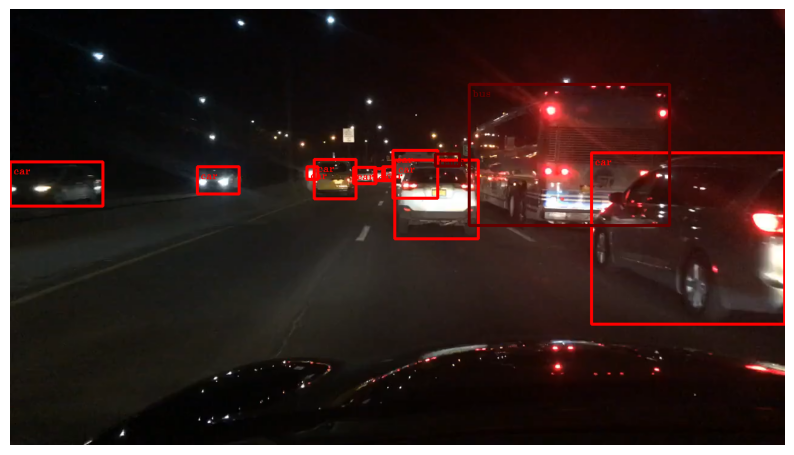

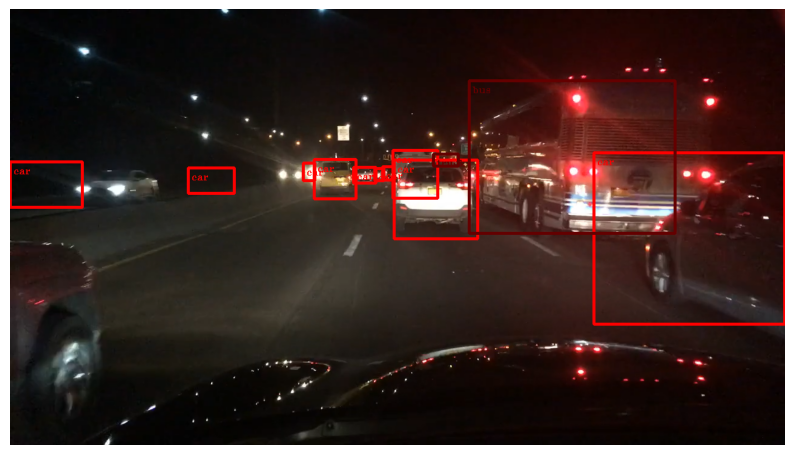

In [9]:
def annotate_frame_with_text(img, frame_labels, color_map, font=cv2.FONT_HERSHEY_TRIPLEX):
    """
    Annoter une image avec des rectangles colorés et ajouter le texte des catégories.
    - img : image OpenCV.
    - frame_labels : DataFrame contenant les labels pour la frame.
    - color_map : dictionnaire mappant les catégories à des couleurs (BGR).
    - font : police utilisée pour le texte (par défaut : cv2.FONT_HERSHEY_TRIPLEX).
    """
    for _, label in frame_labels.iterrows():
        # Coordonner les coins du rectangle
        pt1 = int(label["box2d.x1"]), int(label["box2d.y1"])
        pt2 = int(label["box2d.x2"]), int(label["box2d.y2"])
        color = color_map.get(label["category"], (255, 255, 255))  # Blanc par défaut

        # Ajout du rectangle
        cv2.rectangle(img, pt1, pt2, color, 3)

        # Ajout du texte de la catégorie
        pt_text = pt1[0] + 5, pt1[1] + 20  # Position du texte
        cv2.putText(img, label["category"], pt_text, font, 0.5, color, 1)

    return img

def display_annotated_frame_with_text(video_path, frame_number, video_labels, color_map):
    """
    Extraire une frame spécifique, ajouter des annotations avec texte, et afficher.
    - video_path : chemin de la vidéo.
    - frame_number : numéro de la frame à extraire.
    - video_labels : DataFrame contenant les labels.
    - color_map : dictionnaire mappant les catégories à des couleurs (BGR).
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, img = cap.read()
    cap.release()

    if not ret:
        print(f"Impossible de lire la frame {frame_number} dans {video_path}")
        return

    frame_labels = video_labels.query(f"video_frame == {frame_number}")
    annotated_img = annotate_frame_with_text(img.copy(), frame_labels, color_map)

    display_cv2_img(annotated_img)

frame_number = 0
display_annotated_frame_with_text(output_file, frame_number, video_labels, color_map)

frame_number = 12
display_annotated_frame_with_text(output_file, frame_number, video_labels, color_map)

# Génération et enregistrement d'une vidéo annotée

In [16]:
def add_annotations(img, frame, video_labels, color_map):
    """
    Ajoute des annotations sur une image à partir des labels correspondants.
    - img : image OpenCV.
    - frame : numéro de la frame actuelle.
    - video_labels : DataFrame contenant les labels de la vidéo.
    - color_map : dictionnaire mappant les catégories à des couleurs (BGR).
    """
    # Récupération des labels pour la frame actuelle
    max_frame = video_labels.query("video_frame <= @frame")["video_frame"].max()
    frame_labels = video_labels.query("video_frame == @max_frame")

    # Annotation de l'image
    for _, label in frame_labels.iterrows():
        pt1 = int(label["box2d.x1"]), int(label["box2d.y1"])
        pt2 = int(label["box2d.x2"]), int(label["box2d.y2"])
        color = color_map.get(label["category"], (255, 255, 255))  # Blanc par défaut
        cv2.rectangle(img, pt1, pt2, color, 3)

    return img

def generate_annotated_video(input_video, output_video, video_labels, color_map, fps=30):
    """
    Génère une vidéo annotée et la sauvegarde dans un fichier.
    - input_video : chemin de la vidéo source.
    - output_video : chemin de la vidéo annotée à générer.
    - video_labels : DataFrame contenant les labels de la vidéo.
    - color_map : dictionnaire mappant les catégories à des couleurs (BGR).
    - fps : nombre d'images par seconde pour la vidéo générée.
    """
    # Chargement de la vidéo source
    cap = cv2.VideoCapture(input_video)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Configuration de l'écriture de la vidéo annotée
    out = cv2.VideoWriter(
        output_video,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (frame_width, frame_height)
    )

    # Parcours les frames et ajout des annotations
    for frame in tqdm(range(n_frames), desc="Processing frames"):
        ret, img = cap.read()
        if not ret:
            break

        annotated_img = add_annotations(img, frame, video_labels, color_map)
        out.write(annotated_img)

    # Libération des ressources
    cap.release()
    out.release()
    print(f"Vidéo annotée générée : {output_video}")

input_video = output_file  # Vidéo source
output_video = "annotated_video.mp4"  # Vidéo annotée
generate_annotated_video(input_video, output_video, video_labels, color_map, fps=30)

Processing frames: 100%|██████████| 1205/1205 [00:23<00:00, 51.51it/s]

Vidéo annotée générée : annotated_video.mp4


# Compression et affichage de la vidéo annotée

In [17]:
def compress_video(input_video, output_video, crf=18, preset="veryfast"):
    """
    Compresse une vidéo en utilisant ffmpeg pour réduire sa taille tout en conservant une bonne qualité.
    - input_video : chemin de la vidéo source.
    - output_video : chemin de la vidéo compressée.
    - crf : facteur de qualité (18 = haute qualité, 28 = qualité réduite).
    - preset : paramètre de vitesse pour la compression (plus rapide = fichier plus grand).
    """
    try:
        subprocess.run(
            [
                "ffmpeg",
                "-i", input_video,
                "-crf", str(crf),
                "-preset", preset,
                "-vcodec", "libx264",
                output_video,
                "-loglevel", "quiet"
            ]
        )
        print(f"Vidéo compressée avec succès : {output_video}")
    except Exception as e:
        print(f"Erreur lors de la compression : {e}")

def display_video(video_path, width=600):
    """
    Affiche une vidéo dans un notebook Jupyter.
    - video_path : chemin de la vidéo à afficher.
    - width : largeur de l'affichage en pixels.
    """
    from IPython.display import Video as ipdVideo
    return ipdVideo(video_path, width=width)

# Compression de la vidéo annotée
tmp_output_path = "annotated_video.mp4"  # Vidéo annotée générée précédemment
output_path = "annotated_video_compressed.mp4"  # Vidéo compressée

compress_video(tmp_output_path, output_path, crf=18, preset="veryfast")

# Affichage de la vidéo compressée
display_video(output_path, width=600)

Vidéo compressée avec succès : annotated_video_compressed.mp4


# Rapport du TD6 : Driving Video with Object Tracking

## Objectif
L'objectif de ce TD était d'implémenter un système d'annotations sur une vidéo à partir d'un fichier de labels, puis de générer une vidéo annotée. Nous avons également expérimenté différentes fonctionnalités pour tester les performances de l'algorithme, tout en préservant la vidéo originale.

---

## Étapes Réalisées

### Chargement des Labels
- **Description :**
  Les labels associés à la vidéo ont été chargés depuis un fichier CSV contenant les informations suivantes :
  - Nom de la vidéo (`videoName`)
  - Indice de la frame (`frameIndex`)
  - Catégorie de l'objet (`category`)
  - Coordonnées des boîtes englobantes (`box2d.x1`, `box2d.y1`, `box2d.x2`, `box2d.y2`)
- **Fonction utilisée :**
  `load_video_labels`

---

### Génération d'une Vidéo Annotée
- **Description :**
  À partir de la vidéo originale et des labels chargés, une nouvelle vidéo annotée a été générée. Les annotations comprenaient :
  - Des rectangles colorés autour des objets détectés.
  - Le texte correspondant à la catégorie de chaque objet.

- **Détails :**
  - Les couleurs des rectangles ont été définies selon un dictionnaire `color_map` mappant chaque catégorie à une couleur unique.
  - Les rectangles et les textes ont été ajoutés à chaque frame où des labels étaient disponibles.

- **Fonctions utilisées :**
  - `add_annotations` : Ajoute les rectangles et le texte sur une frame spécifique.
  - `generate_annotated_video` : Parcourt la vidéo frame par frame et applique les annotations.

---

### Gestion des Fichiers
- **Description :**
  Pour éviter d'écraser la vidéo originale, toutes les vidéos annotées ont été sauvegardées avec un nouveau nom. 
  Par exemple :
  - Vidéo originale : `026b9a11-f819c1b9.mp4`
  - Vidéo annotée : `026b9a11-f819c1b9_annotated.mp4`

---

### Visualisation des Annotations
- **Description :**
  Les frames individuelles ont été extraites et affichées pour vérifier les annotations. Chaque frame affichait :
  - Les rectangles colorés autour des objets.
  - Les textes des catégories associés aux rectangles.

- **Fonctions utilisées :**
  - `annotate_frame_with_colors` : Ajoute des rectangles colorés et le texte des catégories sur une frame.
  - `display_annotated_frame_with_colors` : Extrait une frame spécifique et affiche les annotations dans le notebook.

---

### Nettoyage des Fichiers
- **Description :**
  Pour maintenir un répertoire propre, une fonction a été utilisée pour supprimer tous les fichiers `.mp4` et `.mov` du répertoire courant. Cela a permis d'effacer les anciennes vidéos générées.

- **Fonction utilisée :**
  `delete_video_files`

---

## Résultats

### Vidéo Annotée
Une vidéo annotée a été générée avec succès. Les annotations incluaient :
- Des rectangles colorés représentant les objets détectés.
- Les noms des catégories correspondantes affichés au-dessus des rectangles.

### Résolution des Problèmes
**Préservation de la Vidéo Originale :**
   - La vidéo originale n'a jamais été modifiée. Toutes les modifications ont été effectuées sur une copie sauvegardée sous un autre nom.
**Texte Absent :**
   - Le problème initial d'absence de texte dans les annotations a été corrigé en utilisant la fonction `cv2.putText` pour inclure le nom de la catégorie au-dessus des rectangles.

---

## Conclusion
Ce TD a permis de comprendre et de mettre en pratique les concepts suivants :
- Chargement et manipulation de données depuis un fichier CSV.
- Utilisation d'OpenCV pour lire, annoter et générer des vidéos.
- Gestion des fichiers pour éviter de modifier les données sources.

La méthodologie employée garantit que la vidéo originale reste intacte et que les annotations sont appliquées de manière systématique et robuste.